0.045
0.1
0.04
0.1


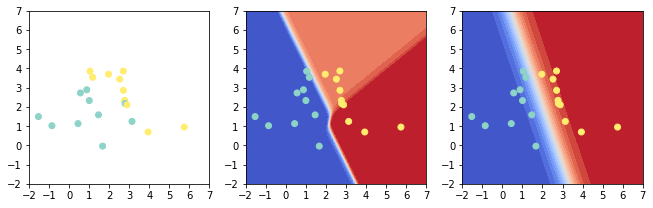

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import tensorflow.keras as km
import tensorflow.keras.layers as kl

%matplotlib inline

mean_1 = np.array([1,2])
mean_2 = np.array([3,3])
cov_1 = np.array([[0.9, 0.3],
                  [0.3, 0.9]])
cov_2 = np.array([[1.2, -0.4],
                  [-0.4, 1.2]])

sigmoid = lambda x: 1/(1+np.e**-x)
sigmoid_derivative = lambda x: sigmoid(x)*(1-sigmoid(x))

tanh = lambda x: (np.e**x - np.e**-x) / (np.e**x + np.e**-x)
tanh_derivative = lambda x: 1 - tanh(x)**2

cost = lambda y_pred, y: 1/2 * np.sum((y_pred - y)**2)
cost_derivative = lambda y_pred,y: y_pred - y

def generate_dataset(N):
    Nh = int(N/2)
    order = np.random.permutation(N)
    X1 = st.multivariate_normal.rvs(mean_1, cov_1, Nh)
    X2 = st.multivariate_normal.rvs(mean_2, cov_2, Nh)
    X = np.concatenate((X1, X2))[order]
    T1 = np.zeros((Nh,1))
    T2 = np.ones((Nh,1))
    T = np.concatenate((T1,T2))[order]
    return X, T

class NeuralNetwork:
    
    def __init__(self, sizes):
        self.layers = sizes
        self.num_layers = len(sizes)
        self.W = [st.norm.rvs(size=(x,y)) for x,y in zip(sizes[:-1],sizes[1:])]
        self.B = [st.norm.rvs(size=(1,y)) for y in sizes[1:]]
        self.H = [tanh for i in range(len(sizes[1:]))]
        self.H[-1] = sigmoid

    def predict(self, X):
        for b, w, h in zip(self.B, self.W, self.H):
            X = h(np.dot(X, w) + b)
        return X

    def backprop(self, x, y):
        A = [x]
        Z = []
        for b, w, h in zip(self.B, self.W, self.H):
            z = (np.dot(x, w) + b)
            Z.append(z)
            x = h(z)
            A.append(x)
        
        delta = cost_derivative(A[-1], y) * sigmoid_derivative(Z[-1])
        
        nabla_B = [np.zeros(b.shape) for b in self.B]
        nabla_W = [np.zeros(w.shape) for w in self.W]
        
        nabla_B[-1] = delta.mean(axis=0)
        nabla_W[-1] = A[-2].T.dot(delta)
        
        for l in range(2, self.num_layers):
            delta = delta.dot(self.W[-l+1].T) * tanh_derivative(Z[-l])
            
            nabla_B[-l] = delta.mean(axis=0)
            nabla_W[-l] = A[-l-1].T.dot(delta)
        return (nabla_B, nabla_W)
    
    def fit(self, X, y, eta = 0.5, epochs = 1000, batch_size=20):
        N = len(X)
        for e in range(epochs):
            order = np.random.permutation(N)
            X = X[order]
            y = y[order]
            nabla_B = [np.zeros(b.shape) for b in self.B]
            nabla_W = [np.zeros(w.shape) for w in self.W]
            batches = [(X[k:k+batch_size],
                       y[k:k+batch_size]) for k in range(0,N,batch_size)]
            for X_batch,y_batch in batches:        
                delta_nabla_B, delta_nabla_W = self.backprop(X_batch, y_batch)
                
                nabla_B = [nb + dnb for nb, dnb in zip(nabla_B, delta_nabla_B)]
                nabla_W = [nw + dnw for nw, dnw in zip(nabla_W, delta_nabla_W)]
                self.W = [w-(eta/len(X_batch))*nw
                        for w, nw in zip(self.W, nabla_W)]
                self.B = [b-(eta/len(X_batch))*nb
                       for b, nb in zip(self.B, nabla_B)]

    def score(self, X, y):
        y_pred = self.predict(X)
        return cost(y_pred, y)

window = (-2,7)
d = 100
a = np.linspace(window[0], window[1], d)
A, B = np.meshgrid(a, a)

def build_custom_nn():
    model = NeuralNetwork([2, 2, 1])
    return model

def build_tf_nn():
    init = km.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    
    model = km.Sequential()
    model.add(kl.Dense(2, input_dim=2, activation='tanh', 
                       kernel_initializer = init,
                       bias_initializer = init))
    #model.add(kl.Dropout(rate = 0.4))
    #model.add(kl.Dense(2, activation='tanh'))
    model.add(kl.Dense(1, activation='sigmoid', 
                       kernel_initializer = init,
                       bias_initializer = init))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

def plot_contour(model):
    C = np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            C[i,j] = model.predict(np.array([[A[i,j], B[i,j]]]))
            
    plt.contourf(A, B, C, cmap='coolwarm', levels=np.linspace(0,1,20))
    
def plot_scatter(X1, X2, y_pred_test):
    plt.scatter(X1, X2, 
                c=y_pred_test.reshape(len(y_pred_test),), 
                cmap='Set3')
    plt.xlim(window)
    plt.ylim(window)
    plt.xticks(np.arange(-2,8,step=1))
    plt.yticks(np.arange(-2,8,step=1))

e = 1000
b = 10
X_train, y_train = generate_dataset(100)
X_test, y_test = generate_dataset(20)

my_nn = build_custom_nn()
my_nn.fit(X_train, y_train, epochs = e, batch_size = b)
my_nn_y_pred_train = np.round(my_nn.predict(X_train))
my_nn_y_pred_test = np.round(my_nn.predict(X_test))
my_nn_training_score = np.round(cost(my_nn_y_pred_train, y_train)/len(y_train), 4)
my_nn_test_score = np.round(cost(my_nn_y_pred_test, y_test)/len(y_test), 4)

tf_nn = build_tf_nn()
tf_nn.fit(X_train, y_train, epochs = e, batch_size = b, verbose=0)
tf_nn_y_pred_train = tf_nn.predict_classes(X_train)
tf_nn_y_pred_test = tf_nn.predict_classes(X_test)
tf_nn_training_score = np.round(cost(tf_nn_y_pred_train, y_train)/len(y_train), 4)
tf_nn_test_score = np.round(cost(tf_nn_y_pred_test, y_test)/len(y_test), 4)

print(my_nn_training_score)
print(my_nn_test_score)
print(tf_nn_training_score)
print(tf_nn_test_score)

plt.figure(figsize=(11,7))
plt.subplot(2,3,1)
plot_scatter(X_test[:,0], X_test[:,1], y_test)
plt.subplot(2,3,2)
plot_contour(my_nn)
plot_scatter(X_test[:,0], X_test[:,1], my_nn_y_pred_test)
plt.subplot(2,3,3)
plot_contour(tf_nn)
plot_scatter(X_test[:,0], X_test[:,1], tf_nn_y_pred_test)

#nn_cm = sm.confusion_matrix(y_train, nn_pred)
#print(nn_cm)